<h1>Table of Contents<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#A-tool-to-visualize-trajectory-frames:-ViewManager" data-toc-modified-id="A-tool-to-visualize-trajectory-frames:-ViewManager-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>A tool to visualize trajectory frames: ViewManager</a></span><ul class="toc-item"><li><span><a href="#Example---show-PT-structures-with-5-largest-and-5-smallest-potential-energies" data-toc-modified-id="Example---show-PT-structures-with-5-largest-and-5-smallest-potential-energies-1.1"><span class="toc-item-num">1.1&nbsp;&nbsp;</span>Example - show PT structures with 5 largest and 5 smallest potential energies</a></span></li><li><span><a href="#Example---plot-an-eigenvector-of-SqRA" data-toc-modified-id="Example---plot-an-eigenvector-of-SqRA-1.2"><span class="toc-item-num">1.2&nbsp;&nbsp;</span>Example - plot an eigenvector of SqRA</a></span></li></ul></li><li><span><a href="#Classify-full-trajectories-in-cells-of-FullGrid" data-toc-modified-id="Classify-full-trajectories-in-cells-of-FullGrid-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>Classify full trajectories in cells of FullGrid</a></span></li><li><span><a href="#Assigning-trajectories-to-a-FullGrid-cell" data-toc-modified-id="Assigning-trajectories-to-a-FullGrid-cell-3"><span class="toc-item-num">3&nbsp;&nbsp;</span>Assigning trajectories to a FullGrid cell</a></span><ul class="toc-item"><li><span><a href="#Test:-assigning-PT-to-a-FullGrid" data-toc-modified-id="Test:-assigning-PT-to-a-FullGrid-3.1"><span class="toc-item-num">3.1&nbsp;&nbsp;</span>Test: assigning PT to a FullGrid</a></span></li><li><span><a href="#Assigning-a-real-trajectory-fo-a-FullGrid" data-toc-modified-id="Assigning-a-real-trajectory-fo-a-FullGrid-3.2"><span class="toc-item-num">3.2&nbsp;&nbsp;</span>Assigning a real trajectory fo a FullGrid</a></span></li></ul></li></ul></div>

In [1]:
import sys
import os

try:
    os.chdir(r"/home/hanaz63/PAPER_MOLECULAR_ROTATIONS_2022/nobackup/molgri")
    sys.path.append(r"/home/hanaz63/PAPER_MOLECULAR_ROTATIONS_2022/nobackup")
except FileNotFoundError:
    os.chdir(r"D:\HANA\phD\PAPER_2022\molecularRotationalGrids")
    sys.path.append(r"D:\HANA\phD\PAPER_2022\molecularRotationalGrids")
    
import warnings
warnings.filterwarnings("ignore")

In [2]:
import nglview as nv
import MDAnalysis as mda
import numpy as np
import time

from scipy.sparse import csr_array
from numpy.typing import NDArray
import matplotlib

from molgri.molecules.transitions import SimulationHistogram, MSM, SQRA
from molgri.plotting.molecule_plots import TrajectoryPlot
import pandas as pd
import matplotlib.pyplot as plt
from molgri.molecules.parsers import FileParser, ParsedEnergy, XVGParser

from molgri.paths import PATH_OUTPUT_PT, OUTPUT_PLOTTING_DATA, PATH_OUTPUT_LOGGING
from molgri.space.fullgrid import FullGrid
from molgri.space.utils import k_argmin_in_array, k_argmax_in_array
from molgri.plotting.widgets import ViewManager

## A tool to visualize trajectory frames: ViewManager

- in Jupyter, using nglview
- input: mda.Universe and one or more indices along the trajectory
- output: frames plotted sequentially or overlapping, color/opacity indicating a property

In [4]:
"""
Some important indices you may wanna plot:
- eigenvectors of SQRA
"""

class PostCalculationEvaluator:
    
    """
    Combine the following (read or use saved if you have it available):
        - trajectory or pseudotrajectory (in form of mda Universe)
        - energies
        - full grid (FullGrid object)
        - transition model(MSM or SQRA object)
        
    
    """
    
    def __init__(self, name_pt, default_atom_selection):
        self.name_pt = name_pt
        self.default_atom_selection = default_atom_selection
        self.u = self.read_u_PT()
        self.parsed_trajectory = self.read_parsed_trajectory_PT()
        self.fg = self.read_fg_PT()
        self.energy = self.read_energy_PT()
        self.transition_model = self.read_sqra_PT()
        
        # just to check if everything is sane
        self._assert_consistent_len()
    
    def _assert_consistent_len(self):
        traj_len = len(self.u.trajectory)
        fg_len = len(self.fg.get_full_grid_as_array())
        energy_len = len(self.energy.energies)
        sqra_len = len(self.transition_model.get_transitions_matrix()[0])
        assert traj_len == fg_len == energy_len == sqra_len
        
    """
    --------------------------------------------------------------------------------------------------
                               Readers to set up all necessary structures.
    --------------------------------------------------------------------------------------------------
    """
    
    def __len__(self):
        traj_len = len(self.u.trajectory)
        return traj_len
    
    def read_u_PT(self):
        return mda.Universe(f"{PATH_OUTPUT_PT}{self.name_pt}.gro", f"{PATH_OUTPUT_PT}{self.name_pt}.xtc")

    def read_parsed_trajectory_PT(self):
        pt_parser = FileParser(f"{PATH_OUTPUT_PT}{self.name_pt}.gro", f"{PATH_OUTPUT_PT}{self.name_pt}.xtc")
        pt = pt_parser.get_parsed_trajectory(default_atom_selection=self.default_atom_selection)
        pt.energies = self.read_energy_PT()
        return pt

    def read_fg_PT(self):

        input_names = None
        full_grid_name = None

        # first step: read the name of the full grid from the log file
        with open(f"{PATH_OUTPUT_LOGGING}{self.name_pt}.log") as f:
            while input_names is None or full_grid_name is None:
                line = f.readline()
                if line.startswith("INFO:PtLogger:input grid parameters:"):
                    input_names = line.strip().split(": ")[-1]
                elif line.startswith("INFO:PtLogger:full grid name:"):
                    full_grid_name = line.strip().split(": ")[-1]
                    
        self.grid_name = full_grid_name
        
        input_names = input_names.split(" ")
        t_input = " ".join(input_names[2:])
        fg = FullGrid(o_grid_name=input_names[0], b_grid_name=input_names[1], t_grid_name=t_input,
                      use_saved=True)

        # second step: load the .npy file with the found name
        used_grid = np.load(f"{OUTPUT_PLOTTING_DATA}get_full_grid_as_array_{full_grid_name}.npy")

        # third step: assert that this is actually the grid that has been used
        assert np.allclose(used_grid, fg.get_full_grid_as_array())

        return fg

    def read_energy_PT(self):
        my_parser = XVGParser(f"/home/hanaz63/nobackup/gromacs/{self.name_pt}/{self.name_pt}.xvg")
        return my_parser.get_parsed_energy()

    def read_sqra_PT(self):
        sh = SimulationHistogram(self.parsed_trajectory, self.fg)
        return SQRA(sh, use_saved=True)
    
    """
    --------------------------------------------------------------------------------------------------
                               Getters to obtain important indices.
    --------------------------------------------------------------------------------------------------
    """    
    
    def get_indices_k_lowest_energies(self, k: int, energy_type: str):
        all_energies = self.energy.get_energies(energy_type)
        return k_argmin_in_array(all_energies, k)
    
    def get_indices_neighbours_of_cell_i(self, i: int):
        adj_array = csr_array(self.fg.get_full_adjacency())[:, [i]].toarray().T[0]
        neighbour_indices = np.nonzero(adj_array)[0]
        return neighbour_indices
    
    def get_indices_same_orientation(self, quaternion_grid_index: int):
        num_positions = self.fg.o_rotations.get_N() * self.fg.t_grid.get_N_trans()
        num_quaternions = self.fg.b_rotations.get_N()
        
        return list(range(quaternion_grid_index, len(self), num_quaternions))
    
    def get_indices_same_position(self, position_grid_index: int):
        num_quaternions = self.fg.b_rotations.get_N()

        return list(range(position_grid_index*num_quaternions, (position_grid_index+1)*num_quaternions))

    """
    --------------------------------------------------------------------------------------------------
                               Getters to obtain a measure of magnitude.
    --------------------------------------------------------------------------------------------------
    """
    
    def get_magnitude_energy(self, energy_type: str):
        return self.energy.get_energies(energy_type)
    
    def get_magnitude_ith_eigenvector(self, i: int):
        evalu, evec = self.transition_model.get_eigenval_eigenvec()
        my_eigenvector = evec[0].T[i]
        return my_eigenvector



class MplColorHelper:

    def __init__(self):
        self.cmap = matplotlib.cm.get_cmap('bwr')
        self.norm = matplotlib.colors.TwoSlopeNorm(vcenter=0) #, vmax=5
        self.scalarMap = matplotlib.cm.ScalarMappable(norm=self.norm, cmap=self.cmap)

    def get_hex(self, val):
        rgba = self.scalarMap.to_rgba(val)
        return matplotlib.colors.rgb2hex(rgba)
        

### Example - show PT structures with 5 largest and 5 smallest potential energies

In [5]:
# EXAMPLE - 

# changeable parameters
my_name1 = "H2O"
my_name2 = "H2O"
my_num = "0099"

my_name = f"{my_name1}_{my_name2}_{my_num}"
my_selection = "bynum 4:6"


# read everything from files 
pce = PostCalculationEvaluator(my_name, my_selection)


# display
vm = ViewManager(pce.u)
vm.fresh_view()

# magnitudes
mch = MplColorHelper()
magnitudes = pce.get_magnitude_energy("Potential")


colors = np.array([mch.get_hex(mag) for mag in magnitudes])


# 5 largest, 5 smallest
num_extremes = 5
argmin_index = k_argmin_in_array(magnitudes, num_extremes)
argmax_index = k_argmax_in_array(magnitudes, num_extremes)
both_index = [*argmax_index, *argmin_index]

print(magnitudes[both_index])

vm.plot_frames_overlapping(both_index, colors=colors[both_index], opacities=[0.5]*len(both_index))

TypeError: SimulationHistogram.__init__() missing 3 required positional arguments: 'full_grid', 'energies', and 'second_molecule_selection'

### Example - plot an eigenvector of SqRA

In [11]:
# EXAMPLE - eigenvector

# display
vm = ViewManager(pce.u)
vm.fresh_view()

# magnitudes
mch = MplColorHelper()
magnitudes = pce.get_magnitude_ith_eigenvector(2)

colors = np.array([mch.get_hex(mag) for mag in magnitudes])


# 5 largest, 5 smallest
num_extremes = 20
argmin_index = k_argmin_in_array(magnitudes, num_extremes)
argmax_index = k_argmax_in_array(magnitudes, num_extremes)
both_index = [*argmax_index, *argmin_index]

print(magnitudes[both_index])

vm.plot_frames_overlapping(both_index, colors=colors[both_index], opacities=[0.5]*len(both_index))
vm.view

[ 0.04037964  0.04410047  0.04660584  0.04643954  0.04623079  0.04595805
  0.04513278  0.06340487  0.13230194  0.22122721  0.12195688  0.09654565
  0.10670643  0.08554157  0.26173064  0.17983264  0.50564893  0.58696169
  0.09340822  0.23770374 -0.16191115 -0.05852288 -0.05026359 -0.05038413
 -0.04650971 -0.05770409 -0.06182747 -0.04265221 -0.04951756 -0.04962655
 -0.04051547 -0.03982912 -0.03966136 -0.03870774 -0.03131237 -0.03124594
 -0.03849364 -0.03580822 -0.03108125 -0.03022683]


NGLWidget()

In [17]:
# not PT
my_path = "/home/hanaz63/nobackup/gromacs/H2O_H2O_0095_2000/"

u_traj = mda.Universe(f"{my_path}H2O_H2O_0095.gro", f"{my_path}fitted_output.xtc")

fg = FullGrid(o_grid_name="12", b_grid_name="8", t_grid_name="linspace(0.2, 1, 20)", use_saved=True)



my_path = "/home/hanaz63/nobackup/gromacs/H2O_H2O_0095_2000/"
topology = f"{my_path}H2O_H2O_0095.gro"
coordinates = f"{my_path}fitted_output.xtc"
energy = f"{my_path}full_energy.xvg"

# preparing the parsed trajectory
my_parser = XVGParser(energy)
pe = my_parser.get_parsed_energy()
pt_parser = FileParser(
    path_topology=topology,
    path_trajectory=coordinates)
parsed_trajectory = pt_parser.get_parsed_trajectory(default_atom_selection="bynum 4:6")
parsed_trajectory.energies = pe


sm = SimulationHistogram(parsed_trajectory, fg)
my_array1 = sm.get_all_assignments()

cell_74 = np.where(my_array1==74)[0]
print(cell_74)

#view = nv.show_mdanalysis(u_traj)
#view.add_unitcell()
#view
vm = ViewManager(u_traj)
vm.fresh_view()
vm.plot_frames_overlapping(cell_74)

[1573 1574 1575 1576 1577 1578 1579 1580 1581 1582 1583 1584 1585 1586
 1587 1588 1589 1590 1591 1592 1593 1594 1595 1596 1597 1598 1599 1779
 1780 1781 1782 1783 1784 1785 1786 1787 1788 1789 1790 1791 1792 1793
 1794 1795 1796 1797 1798 1799 1800 1801]


NGLWidget()

In [19]:
all_energies = parsed_trajectory.energies.get_energies("Potential")
lowest_E = k_argmin_in_array(all_energies, 20)
print(lowest_E)
vm.fresh_view()
vm.plot_frames_overlapping(lowest_E)

[1059 1065 1064 1063 1298 1297 1296 1295 1294 1293 1292 1062 1061 1060
 1056 1057 1058 1291 1299 1066]


NGLWidget()

## Classify full trajectories in cells of FullGrid

In [105]:
from molgri.molecules.writers import PtIOManager

from MDAnalysis.coordinates.memory import MemoryReader
from MDAnalysis.analysis.base import AnalysisFromFunction

def _extract_universe_second_molecule(original_universe, selection_criteria):
    m2 = original_universe.select_atoms(selection_criteria)

    coordinates = AnalysisFromFunction(lambda ag: ag.positions.copy(), m2).run().results['timeseries']
    u2 = mda.Merge(m2)
    u2.load_new(coordinates, format=MemoryReader)
    return u2


def assign_trajectory_2_quaternion_grid(trajectory_universe: mda.Universe, m1_name, m2_name, b_grid_name,
                                       second_molecule_selection):
    
    # create PT on quaternion-only grid
    manager = PtIOManager(m1_name, m2_name, o_grid_name="1", b_grid_name=b_grid_name, 
                          t_grid_name="[0.1]")
    my_pt = manager.construct_pt()
    my_pt_name = manager.get_name()
    pt_sec_mol_universe = mda.Universe(f"{PATH_OUTPUT_PT}{my_pt_name}.gro", f"{PATH_OUTPUT_PT}{my_pt_name}.xtc")
    
    # in the real and pt trajectory, extract the second molecule and center it without rotating
    trajectory_universe_m2 = _extract_universe_second_molecule(trajectory_universe, second_molecule_selection)
    pt_universe_m2 = _extract_universe_second_molecule(pt_sec_mol_universe, second_molecule_selection)
    # move them to center - curently doing that later
    #workflow = [mda.transformations.center_in_box(real_traj_sec_mol.atoms, center="mass", point=(0, 0, 0))]
    #real_traj_sec_mol.trajectory.add_transformations(*workflow)
    
    # calculate RMSD between both
    total_results = []
    for i, ts in enumerate(pt_universe_m2.trajectory):
        results = []
        for j, ts2 in enumerate(trajectory_universe_m2.trajectory):
            results.append(mda.analysis.rms.rmsd(real_traj_sec_mol.trajectory[j].positions, 
                                                 pt_sec_mol.trajectory[i].positions,
                                                center=True, weights=real_traj_sec_mol.atoms.masses))
        total_results.append(results)
    total_results = np.array(total_results)
    clases = np.argmin(total_results, axis=0)
    return clases

    

my_cl = assign_trajectory_2_quaternion_grid(u_traj, "H2O", "H2O", "8", "bynum 4:6")
print(np.unique(my_cl, return_counts=True))

Warning! Voronoi objects can only be created for >=4 points
(array([0, 1, 2, 3, 4, 5, 6, 7]), array([362, 108, 341, 279,  94, 298, 168, 351]))


In [99]:
selected_class = 4

vm = ViewManager(pt_sec_mol)
vm.fresh_view()
vm.plot_ith_frame(selected_class)


NGLWidget()

In [109]:
for selected_class in range(8):
    vm = ViewManager(real_traj_sec_mol)
    vm.fresh_view()
    vm.plot_frames_overlapping(np.where(clases==selected_class)[0][::20])
    display(vm.view)

NGLWidget()

NGLWidget()

NGLWidget()

No such comm: d8094022ff5c4ebaa76b0652b1ce9cb2
No such comm: d8094022ff5c4ebaa76b0652b1ce9cb2
No such comm: d8094022ff5c4ebaa76b0652b1ce9cb2
No such comm: d8094022ff5c4ebaa76b0652b1ce9cb2
No such comm: abd4465b4061480ebea46779f139d442
No such comm: abd4465b4061480ebea46779f139d442
No such comm: abd4465b4061480ebea46779f139d442
No such comm: abd4465b4061480ebea46779f139d442
No such comm: abd4465b4061480ebea46779f139d442
No such comm: abd4465b4061480ebea46779f139d442
No such comm: abd4465b4061480ebea46779f139d442
No such comm: 3c1bcd991af043de976f3f7720075493
No such comm: 3c1bcd991af043de976f3f7720075493
No such comm: 3c1bcd991af043de976f3f7720075493
No such comm: 3c1bcd991af043de976f3f7720075493
No such comm: 3c1bcd991af043de976f3f7720075493
No such comm: 3c1bcd991af043de976f3f7720075493
No such comm: 3c1bcd991af043de976f3f7720075493
No such comm: d8094022ff5c4ebaa76b0652b1ce9cb2
No such comm: abd4465b4061480ebea46779f139d442
No such comm: 3c1bcd991af043de976f3f7720075493


In [ ]:
# TODO: enable different colormaps
# TODO: enable expressing magnitude as opacity
# TODO: enable plotting only the most extrem values (most + and - for eigenvector)
# TODO: plot eigenvectors and see if they are sensible
# TODO: also plot 1D eigenvectors sorted by orientation/position
# TODO: network flow plot for strongest rates?

# TODO: make transition matrix determination faster and try it for a large matrix
# TODO: HF forcefield and calculations
# TODO: enable the same for plotting for simulations (real trajectories)

## Assigning trajectories to a FullGrid cell
- input: (pseudo)trajectory and a FullGrid of choice
- assign structures to position, orientation or full classes (cells of FullGrid) 


### Test: assigning PT to a FullGrid

- if assigning to its own fg, assignments should be 1:1
- if assigning to a smaller fg, an uniform number per cell is expectes

### Assigning a real trajectory fo a FullGrid

In [5]:
my_fg = FullGrid("8", "12", "[0.2, 0.3, 0.4, 0.5, 2]")
folder_name = "/home/hanaz63/nobackup/gromacs/H2O_H2O_0095_5200/"
my_trajectory_name = "H2O_H2O_0095"

my_universe = mda.Universe(f"{folder_name}{my_trajectory_name}.gro", f"{folder_name}{my_trajectory_name}.xtc")

sh = SimulationHistogram(my_universe, full_grid=my_fg, second_molecule_selection="bynum 4:6",
                         trajectory_name=my_trajectory_name)

energies = XVGParser(f"{folder_name}full_energy.xvg").get_parsed_energy()


In [11]:
# most populated cells 
my_indices, my_counts = np.unique(assignments.astype(int), return_counts=True)
most_populated_cells = my_indices[k_argmax_in_array(my_counts, 5)]
vm = ViewManager(sh.trajectory_universe)
for selected_class in most_populated_cells:
    vm.fresh_view()
    vm.plot_frames_overlapping(np.where(assignments==selected_class)[0][::10])
    display(vm.view)

NGLWidget()

NGLWidget()

NGLWidget()

NGLWidget()

NGLWidget()

In [32]:
# are the most populated cells also the ones with lowest average energy?
# maybe not because the size of the cell strongly affects the population
all_popular_frames = []
full_assignments = sh.get_full_assignments().astype(int)
my_indices, my_counts = np.unique(full_assignments, return_counts=True)
most_populated_cells = my_indices[k_argmax_in_array(my_counts, 3)]
for populated_cell in most_populated_cells:
    belongs_to_this = np.where(sh.get_full_assignments()==populated_cell)[0]
    all_popular_frames.extend(belongs_to_this)

cell_volumes = np.array(sh.full_grid.get_total_volumes())
volume_per_assignment = cell_volumes[full_assignments]

pot_energy = energies.get_energies("Potential")/volume_per_assignment
print("Popular frames energy", np.min(pot_energy[all_popular_frames]), np.average(pot_energy[all_popular_frames]),
     np.max(pot_energy[all_popular_frames]))
print("All frames energy", np.min(pot_energy), np.average(pot_energy),
     np.max(pot_energy))

In 4D, only approximate calculation of Voronoi cells is possible. Proceeding numerically.
Popular frames energy -2.0006643985676114 -1.3498219344767182 0.10333779877108565
All frames energy -2.199330928905284 -1.0530307013919278 0.10333779877108565


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 18/18 [00:03<00:00,  5.76it/s]


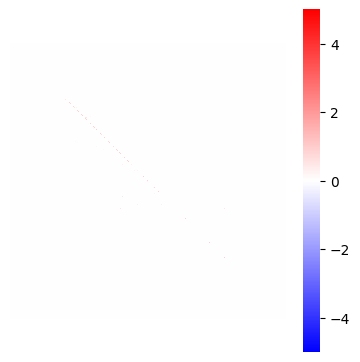

In [6]:
from molgri.plotting.transition_plots import TransitionPlot
my_msm = MSM(sh, energies)
my_tp = TransitionPlot(my_msm)
my_tp.plot_heatmap(save=False)

In [7]:
my_tp.plot_its(save=False)

  0%|                                                                                                                                                                                                                                               | 0/18 [11:21<?, ?it/s]


ArpackNoConvergence: ARPACK error -1: No convergence (100001 iterations, 0/6 eigenvectors converged) [ARPACK error -14: DNAUPD  did not find any eigenvalues to sufficient accuracy.]